In [28]:
hard = 0 #0 for screen copy, 1 for hard copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib tk
from scipy.optimize import curve_fit
import sys
sys.path.insert(0,r"E:\Simon_Files")
import scipy as sp
from astropy.io import fits
import os

In [29]:
def readfits(filename, exten_no):
    with fits.open(filename) as hdul:
        data = hdul[exten_no].data
    return data

def gaussian(x, a, x0, sigma, c):
    return c + a * np.exp(-(x - x0)**2 / (2 * sigma**2))

folder_name = r'E:\\Simon_Files\\'
file_name = r'data_for_gordon_SiIV1394_oct242015.fits'

In [37]:
wavelength = readfits(folder_name + file_name, exten_no=0)
intensity = readfits(folder_name + file_name, exten_no=1)
time = readfits(folder_name + file_name, exten_no=2)

# Transpose the intensity array to match the expected shape
intensity = np.transpose(intensity, (2, 1, 0))

n_lambda = wavelength.shape[0]
n_time = time.shape[0]
n_pos = 30

coeff_fit = np.zeros((n_time, n_pos, 4), dtype=float)  # set of gaussian fit coefficients
int_gauss = np.zeros((n_lambda, n_time, n_pos), dtype=float)

In [38]:
np.shape(wavelength)
np.shape(intensity[:, i_time, i_pos])

(40,)

C:\Users\valer\AppData\Local\Temp\ipykernel_23692\4283127127.py:44: RuntimeWarning: invalid value encountered in sqrt
  v_excess[i_time, i_pos] = np.sqrt(((sdev[i_time, i_pos] / rest_wavelength) * 3e10 / v_thermal) ** 2 - 1)
C:\Users\valer\AppData\Local\Temp\ipykernel_23692\4283127127.py:43: RuntimeWarning: invalid value encountered in sqrt
  sdev[i_time, i_pos] = np.sqrt(norm_moment[i_time, i_pos, 2])
c:\Users\valer\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<Figure size 640x480 with 0 Axes>

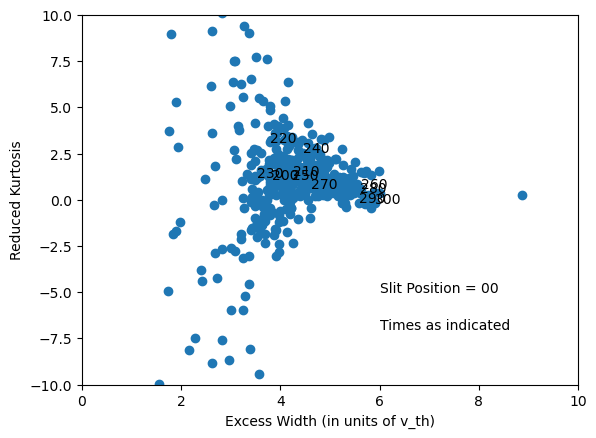

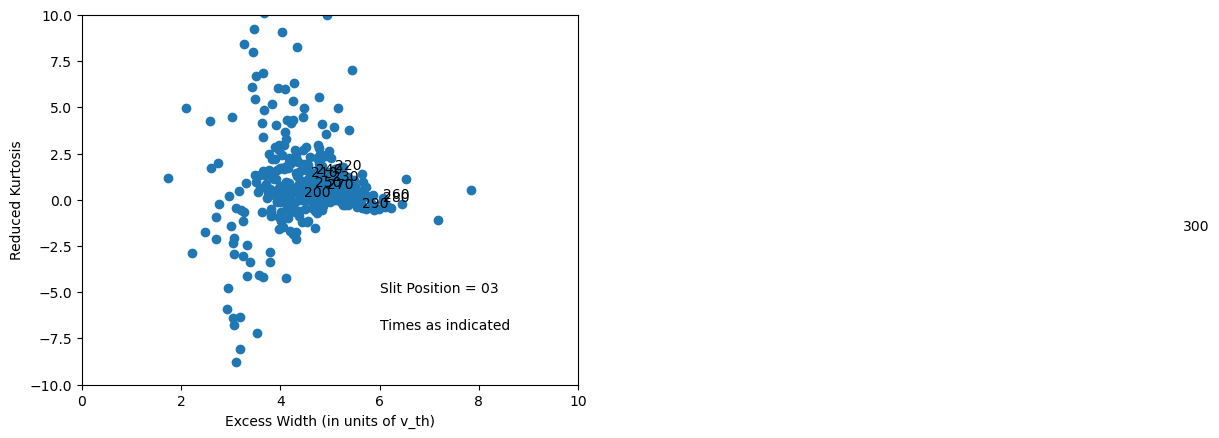

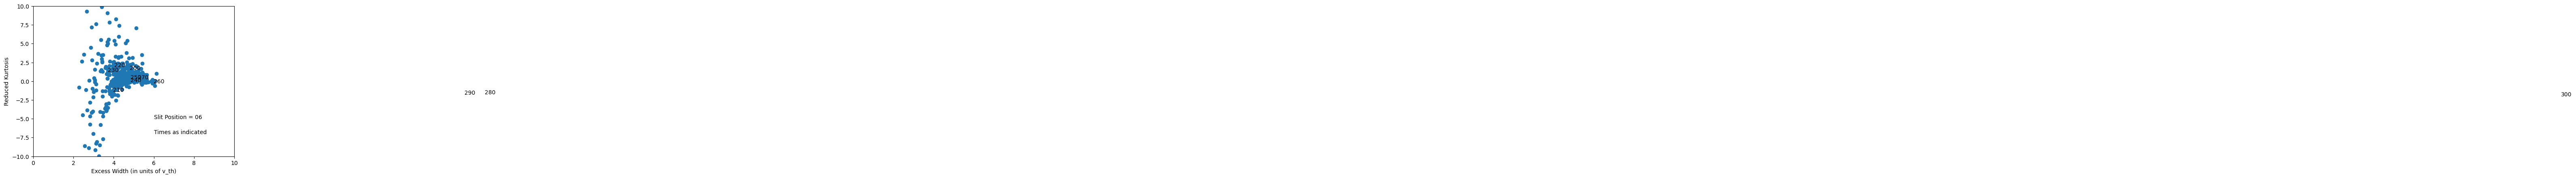

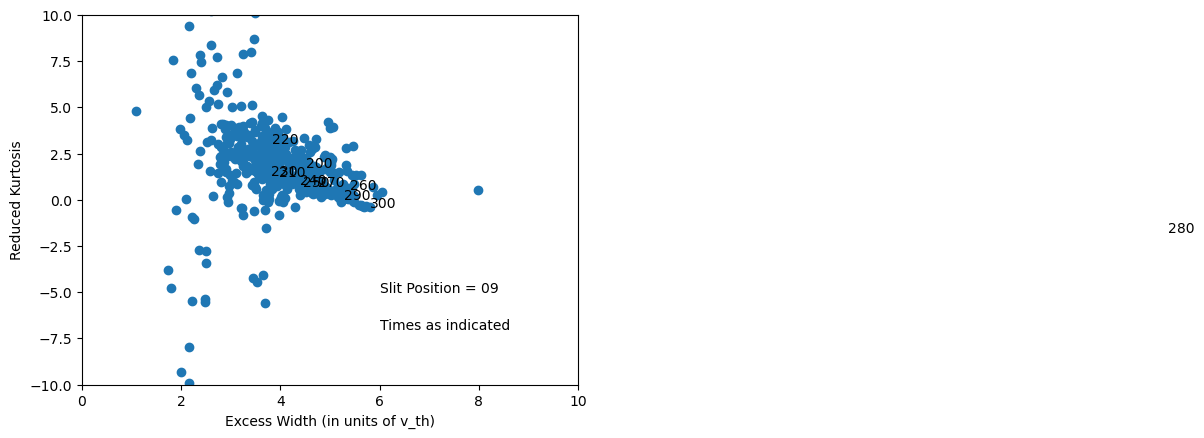

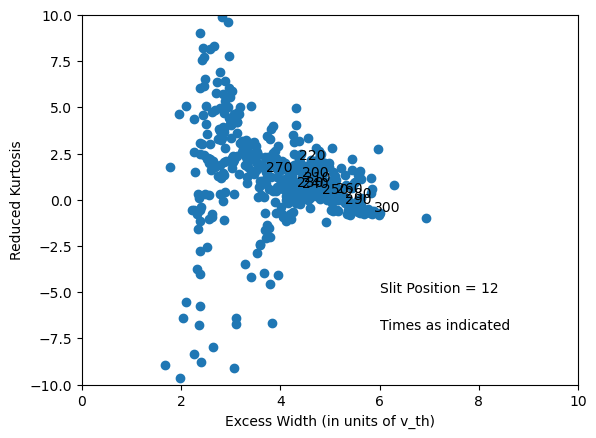

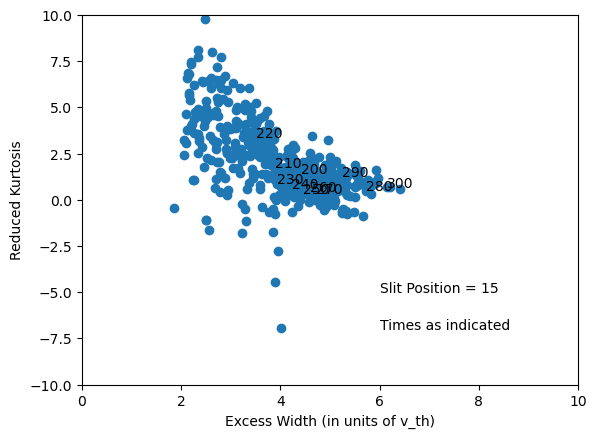

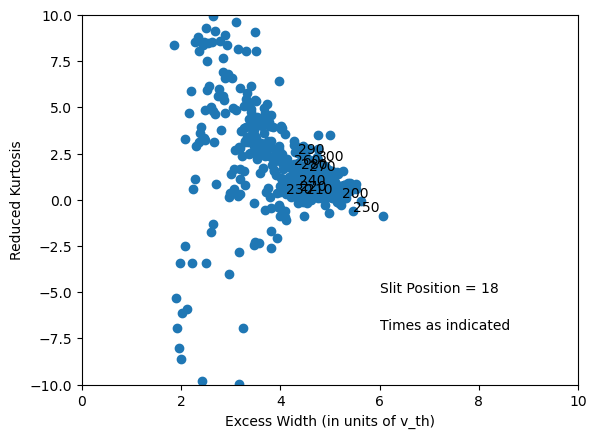

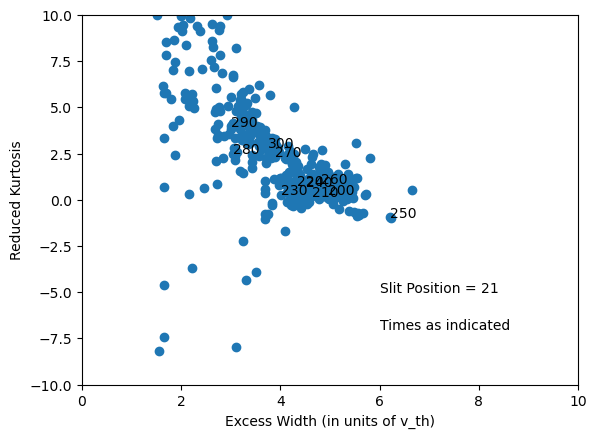

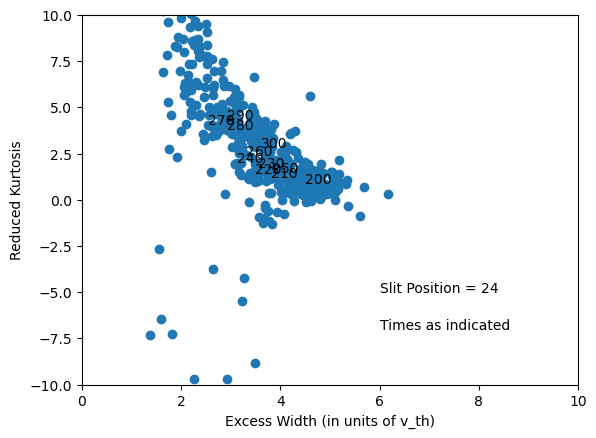

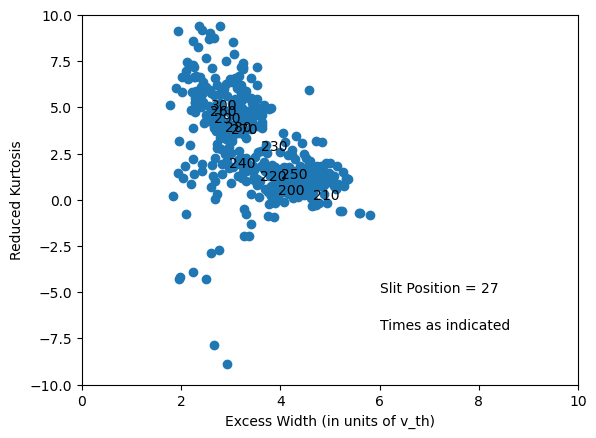

In [41]:
for i_pos in range(0, n_pos, 3):
    if hard == 0:
        plt.figure(i_pos // 3)
    else:
        plt.rcParams.update({'font.size': 18, 'lines.linewidth': 3, 'axes.linewidth': 3})
        plt.switch_backend('agg')
        filename = os.path.join(folder_name, f'width_and_kurtosis_position_{i_pos:02d}.eps')

    for i_time in range(n_time):
        popt, _ = curve_fit(gaussian, wavelength, intensity[:, i_time, i_pos], p0=[1, np.mean(wavelength), 1, 1], maxfev=1000000)
        coeff_fit[i_time, i_pos, :] = popt
        int_gauss[:, i_time, i_pos] = gaussian(wavelength, *popt)

    delta_lambda = np.zeros((n_lambda, n_time, n_pos), dtype=float)
    raw_moment = np.zeros((n_time, n_pos, 5), dtype=float)
    norm_moment = np.zeros((n_time, n_pos, 5), dtype=float)
    sdev = np.zeros((n_time, n_pos), dtype=float)
    v_excess = np.zeros((n_time, n_pos), dtype=float)
    red_kurt = np.zeros((n_time, n_pos), dtype=float)

    t_formation = 7e4 #spectral formation temperature (K)
    ion_mass = 28. * 1.67e-24 #mass of ion
    rest_wavelength = 1394. #peak wavelength

    v_thermal = np.sqrt(1.38e-16 * t_formation / ion_mass)

    #i_lambda_low=0
    #i_lambda_high=n_lambda-1
    i_lambda_low = 5
    i_lambda_high = 30

    for i_time in range(n_time):
        for i_lambda in range(i_lambda_low, i_lambda_high + 1):
            delta_lambda[i_lambda, i_time, i_pos] = wavelength[i_lambda] - coeff_fit[i_time, i_pos, 1]

        for n_mom in range(5):
            for i_lambda in range(i_lambda_low, i_lambda_high + 1):
                raw_moment[i_time, i_pos, n_mom] += (delta_lambda[i_lambda, i_time, i_pos] ** n_mom) * intensity[i_lambda, i_time, i_pos]

        for n_mom in range(5):
            norm_moment[i_time, i_pos, n_mom] = raw_moment[i_time, i_pos, n_mom] / raw_moment[i_time, i_pos, 0]

        sdev[i_time, i_pos] = np.sqrt(norm_moment[i_time, i_pos, 2])
        v_excess[i_time, i_pos] = np.sqrt(((sdev[i_time, i_pos] / rest_wavelength) * 3e10 / v_thermal) ** 2 - 1)
        red_kurt[i_time, i_pos] = norm_moment[i_time, i_pos, 4] / sdev[i_time, i_pos] ** 4 - 3

    plt.figure()
    plt.plot(v_excess[:, i_pos], red_kurt[:, i_pos], 'o')
    plt.xlabel('Excess Width (in units of v_th)')
    plt.ylabel('Reduced Kurtosis')
    plt.xlim([0, 10])
    plt.ylim([-10, 10])
    plt.text(6, -5, f'Slit Position = {i_pos:02d}')
    plt.text(6, -7, 'Times as indicated')

    for i_time in range(200, 301, 10):
        plt.text(v_excess[i_time, i_pos], red_kurt[i_time, i_pos], f'{i_time:03d}')

    if hard == 1:
        plt.savefig(filename, format='eps')
        plt.close()

    if hard == 1:
        plt.rcParams.update({'font.size': 12, 'lines.linewidth': 1, 'axes.linewidth': 1})